In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [2]:
"""Data"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/Benchmark_evaporation_products/DOLCE_v3'

DOLCE_v3_monthly = xr.open_dataset(home + '/DOLCE_v3_2001-2010_720x360_yearsum_timmean.nc' , engine = 'netcdf4')

"""Converting to mm/d"""

labda = 2.45 * 10**6 #MJ kg^-1
rho_w = 1000  #kg m ^-3
t_day = 86400 #seconds
factor = (t_day * 1000)/(rho_w * labda)

DOLCE_v3 = DOLCE_v3_monthly.hfls[:,:,:] * factor

"""Precipitation data"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/GSWP3/Monthly'

Prec_monthly_2001_2010 = xr.open_dataset(home +  '/pr_gswp3_2001_2010_monthly_timmean_invLat.nc' , engine = 'netcdf4')
P_mean = Prec_monthly_2001_2010.pr * 86400 * 30.4

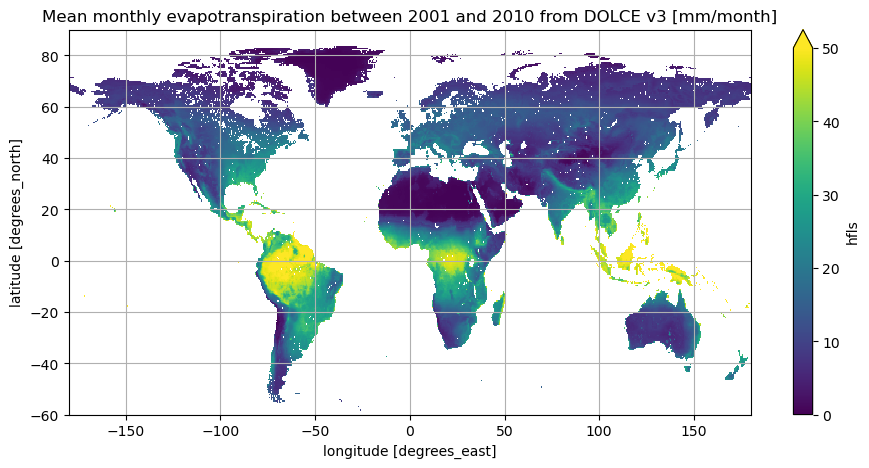

In [3]:
"""plotting evapotranspiration map"""


plt.figure(figsize = (11, 5))

DOLCE_v3[0 , : , :].plot(cmap = 'viridis' , vmin = 0 , vmax = 50)
plt.title('Mean monthly evapotranspiration between 2001 and 2010 from DOLCE v3 [mm/month]')
plt.ylim(-60 , 90)
plt.grid()

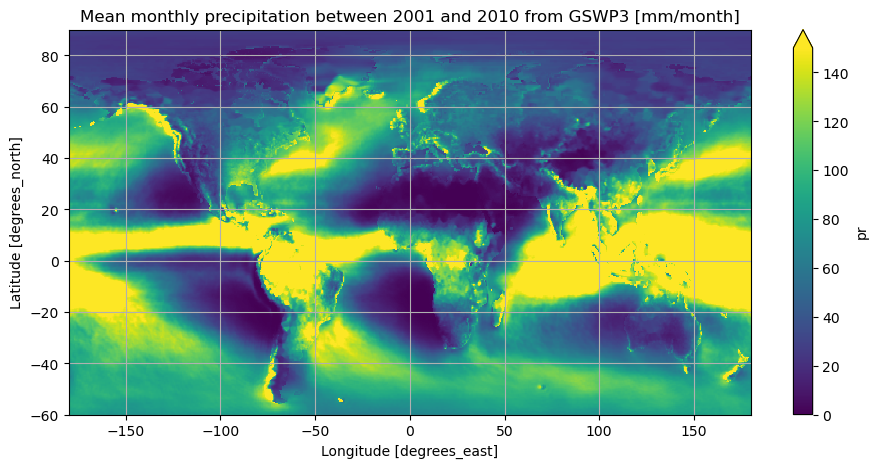

In [4]:
"""plotting evapotranspiration map"""


plt.figure(figsize = (11, 5))

P_mean[0 , : , :].plot(cmap = 'viridis' , vmin = 0 , vmax = 150)
plt.title('Mean monthly precipitation between 2001 and 2010 from GSWP3 [mm/month]')
plt.ylim(-60 , 90)
plt.grid()

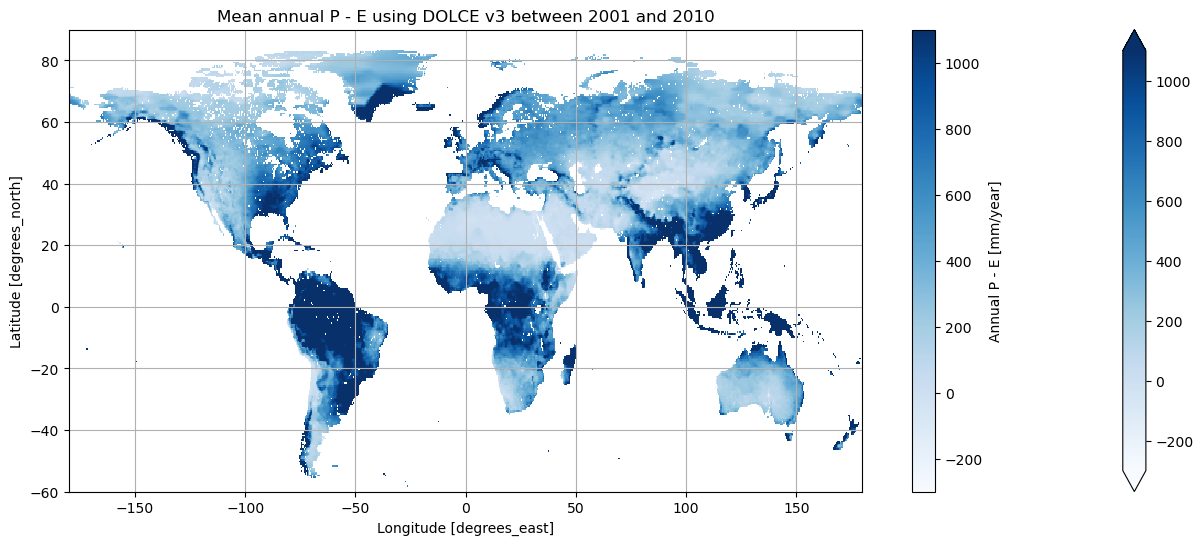

In [5]:
#Substracting P - ET

import numpy as np
from matplotlib.colors import ListedColormap

original_cmap = plt.get_cmap('Blues')
colors = original_cmap(np.linspace(0, 1, 256))
reversed_cmap = ListedColormap(np.flip(colors, axis=0))

A = DOLCE_v3
B = P_mean
A = A.astype('float64')
B = B.astype('float64')

t = B[0]*12 - A[0]*12

# Create a figure and axis for the plot
fig,ax = plt.subplots(figsize = (16, 6))

# Plot the data
im = t.plot(cmap = 'Blues' , vmin = -300 , vmax = 1100)

# Add a colorbar to the plot
cbar = plt.colorbar(im, ax=ax)

# Label the colorbar
cbar.set_label('Annual P - E [mm/year]')

plt.title('Mean annual P - E using DOLCE v3 between 2001 and 2010')
plt.ylim(-60 , 90)
plt.grid()

In [7]:
import xarray as xr
import numpy as np

"""Data"""

home = '/scratch/pdenblaauwen/rootzone/rootzone/GSWP3/Daily'

Tas = xr.open_dataset(home + '/tas_gswp3_2001_2010_timmean.nc')
Tas_min = xr.open_dataset(home + '/tasmin_gswp3_2001_2010_timmean.nc')
Tas_max = xr.open_dataset(home + '/tasmax_gswp3_2001_2010_timmean.nc')

def hargreaves_samani(tmax, tmin, tmean, latitude):
    
    # extraterrestrial radation
    G = 0.0820  #MJ m^-2 min^-1
    phi = latitude/360 * (2*np.pi) #rad
    d = np.zeros(365)
    delta = np.zeros(365)
    for J in range(365):
        d[J] = 1 + 0.033 * np.cos(0.0172 * J) #[-]
        delta[J] = 0.409 * np.sin(0.0172 * J - 1.39) #rad
    d = d.mean()
    delta = delta.mean()
    w = np.arccos(-np.tan(phi)*np.tan(delta)) #rad
    Re = (24*60)/np.pi * G * d * (w*np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta)*np.sin(w)) #MJ m^-2 d^-1

    # Calculate the potential evapotranspiration
    labda = 2.45 # MJ kg^-1
    alpha = 0.0023
    Ep = (1/labda) * alpha * Re * ((tmean-273.15) + 17.8) * np.sqrt((tmax-273.15)-(tmin-273.15))
    return Ep

pet = hargreaves_samani(tmax = Tas_max.tasmax , tmin = Tas_min.tasmin , tmean = Tas.tas , latitude = Tas.lat[10:320]) * 30

(-60.0, 80.0)

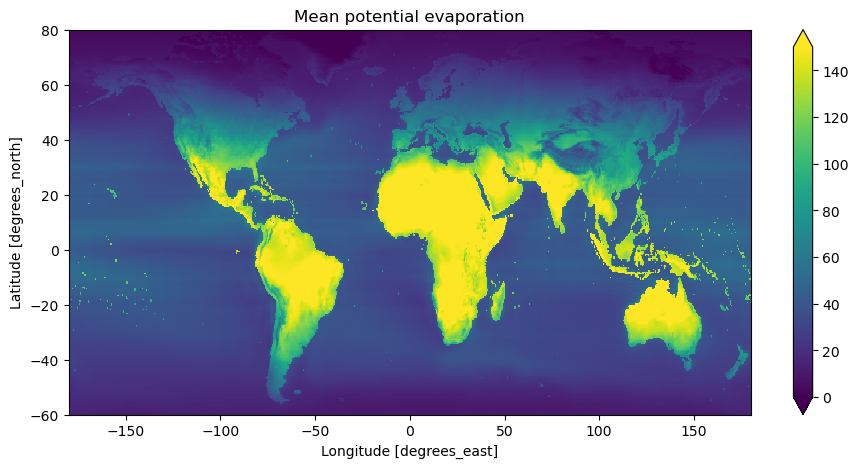

In [9]:
plt.figure(figsize = (11, 5))
pet.plot(vmin = 0 , vmax = 5 * 30)

plt.title('Mean potential evaporation')

plt.ylim(-60 , 80)

(-60.0, 80.0)

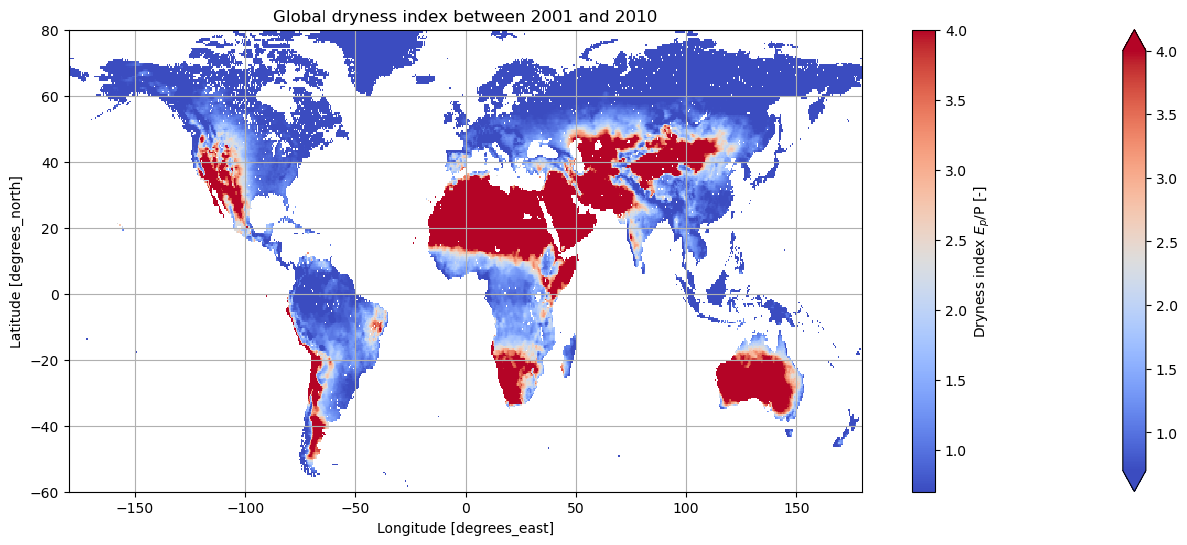

In [20]:
#Dryness index

original_cmap = plt.get_cmap('coolwarm')
colors = original_cmap(np.linspace(0, 1, 256))
reversed_cmap = ListedColormap(np.flip(colors, axis=0))

PET = pet[: , 0 , :]
P = P_mean
A = PET/P - t/1000000000000000000 #To remove the sea

# Plot the data
fig,ax = plt.subplots(figsize = (16, 6))
im = A.plot(cmap = 'coolwarm' , vmin = 0.7 , vmax = 4)



# Add a colorbar to the plot
cbar = plt.colorbar(im, ax=ax)

# Label the colorbar
cbar.set_label(r'Dryness index $E_p$/P [-]')

plt.grid()
plt.title('Global dryness index between 2001 and 2010')
plt.ylim(-60 , 80)

(-60.0, 80.0)

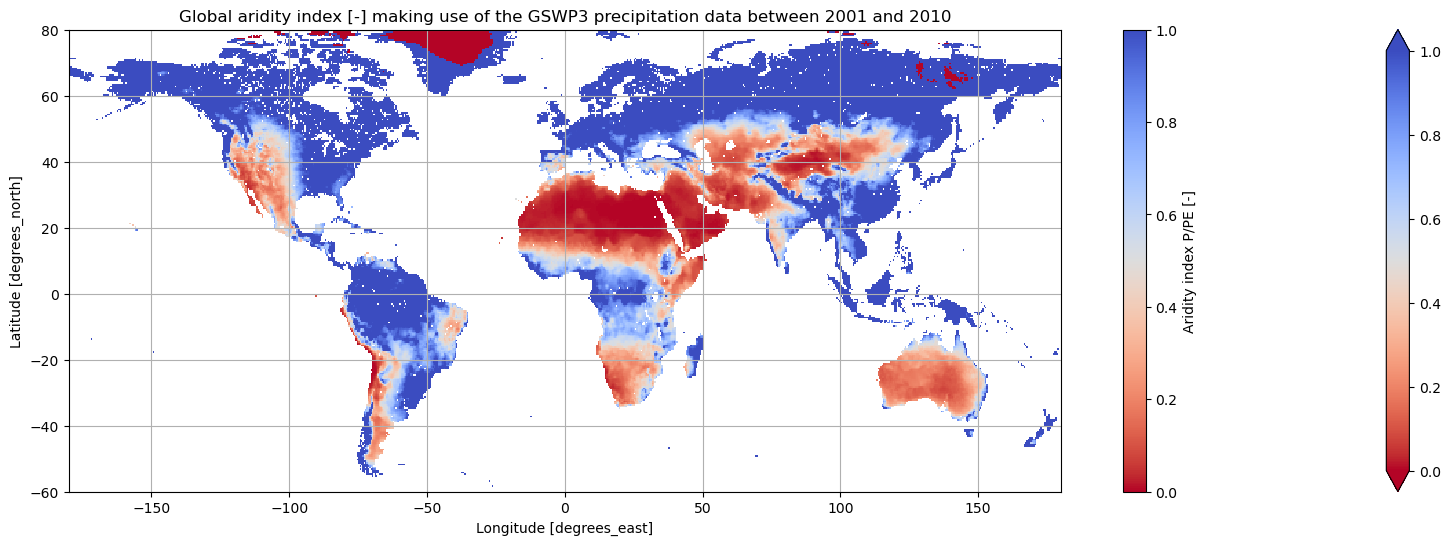

In [11]:
#Aridity index

original_cmap = plt.get_cmap('coolwarm')
colors = original_cmap(np.linspace(0, 1, 256))
reversed_cmap = ListedColormap(np.flip(colors, axis=0))

A = P/PET - t/1000000000000000000 #To remove the sea

# Plot the data
fig,ax = plt.subplots(figsize = (20, 6))
im = A.plot(cmap = reversed_cmap , vmin = 0 , vmax = 1.0)

# Add a colorbar to the plot
cbar = plt.colorbar(im, ax=ax)

# Label the colorbar
cbar.set_label('Aridity index P/PE [-]')

plt.ylim(-60 , 80)
plt.grid()
plt.title('Global aridity index [-] making use of the GSWP3 precipitation data between 2001 and 2010')
plt.ylim(-60 , 80)

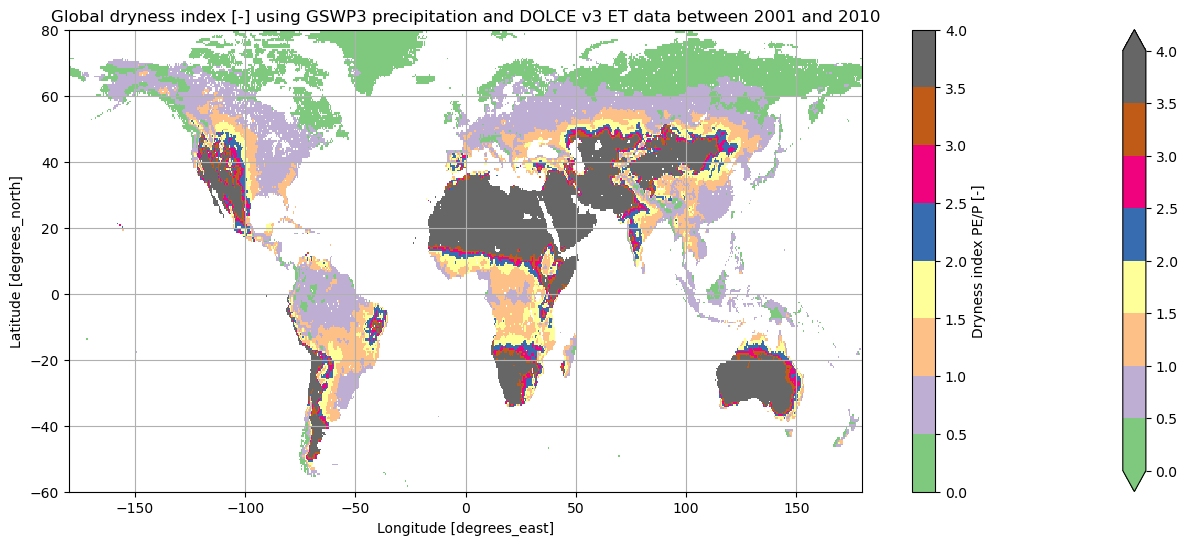

In [12]:
#Water and energy limited

PET = pet[: , 0 , :]
P = P_mean
A = PET/P - t/1000000000000000000 #To remove the sea

# Plot the data
fig,ax = plt.subplots(figsize = (16, 6))
im = A.plot(cmap = 'Accent' , vmin = 0 , vmax = 4)

# Add a colorbar to the plot
cbar = plt.colorbar(im, ax=ax)

# Label the colorbar
cbar.set_label('Dryness index PE/P [-]')

plt.grid()
plt.title('Global dryness index [-] using GSWP3 precipitation and DOLCE v3 ET data between 2001 and 2010')
plt.ylim(-60 , 80);

print()